<a href="https://colab.research.google.com/github/golfwhiper28/nida_is/blob/main/code/Regression_V2_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare the enviorment

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6c1e3f2d-4724-63f0-0919-91c4ad8c14a7)


In [ ]:
import sys
print(f"Python{sys.version}\n")

import numpy as np
print(f"Numpy{np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow{tf.__version__}\n")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

#Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TendorFlow detected {len(gpus)} GPU(s):")
for i,gpu in enumerate(gpus):
  print(f"...GPU No. {i}: Name = {gpu.name}, Type ={gpu.device_type}")

Python3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

Numpy1.21.6

TensorFlow2.8.2

tf.keras.backend.image_data_format() = channels_last
TendorFlow detected 1 GPU(s):
...GPU No. 0: Name = /physical_device:GPU:0, Type =GPU


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys,os,time,datetime
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D,SimpleRNN
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Define Functions

In [ ]:
def loaddata():
  path = "/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/BTCUSDT_Hourly.csv"
  df_trans = pd.read_csv(path)
  df_trans[['open_date', 'open_times']] = df_trans['open_time'].str.split(' ', 1, expand=True)
  df_trans[['close_date', 'close_times']] = df_trans['close_time'].str.split(' ', 1, expand=True)
  df_trans["open_date"] = pd.to_datetime(df_trans["open_date"],format='%Y-%m-%d')
  df_trans["close_date"] = pd.to_datetime(df_trans["close_date"],format='%Y-%m-%d')
  df_trans["open_times"] = pd.to_datetime(df_trans["open_times"],format='%H:%M:%S').dt.time
  df_trans["close_times"] = pd.to_datetime(df_trans["close_times"],format='%H:%M:%S').dt.time
  df_trans["open_time"] = pd.to_datetime(df_trans['open_time'], format='%Y-%m-%d %H:%M:%S')
  df_trans["close_time"] = pd.to_datetime(df_trans['close_time'], format='%Y-%m-%d %H:%M:%S')
  df_trans = df_trans.sort_values(by='open_time').reset_index(drop=True)
  return df_trans

In [ ]:
# Split close price and return
def window_return(val, window):
  lst_x = []
  lst_y = []
  lst_x_return = []
  lst_y_return = []
  for i in range(0,len(val) - window -1,1):
    first_price = val[i]
    lst_x.append(val[i:i+window])
    lst_y.append(val[i+window])
    lst_x_return.append((val[i+1:i+window]-first_price)/first_price)
    lst_y_return.append((val[i+window]-first_price)/first_price)
  array_x_return = np.array(lst_x_return).reshape(-1,window-1)
  array_y_return = np.array(lst_y_return).reshape(-1,1)
  array_x = np.array(lst_x).reshape(-1,window)
  array_y = np.array(lst_y).reshape(-1,1)
  return array_x,array_x_return,array_y,array_y_return

In [ ]:
def split(x_array, y_array, ratio_train=0.8, ratio_test=0.1):
  n_data = x_array.shape[0]
  n_train = int(n_data * ratio_train)    
  n_test = int(n_data *ratio_test)       
  n_val = n_data -n_train -n_test

  x_train, y_train = x_array[:n_train], y_array[:n_train] 
  x_val, y_val      = x_array[n_train:n_train+n_val], y_array[n_train:n_train+n_val]
  x_test, y_test   = x_array[n_train+n_val:], y_array[n_train+n_val:]
  return [x_train, x_val, x_test], [y_train, y_val, y_test]

In [ ]:
def norm_val(norm_fn, lst_x, lst_y):
  return_x = [i for i in lst_x ]
  return_y = [i for i in lst_y ]
  for i in range(len(lst_x)):
    return_x[i] = norm_fn.transform(lst_x[i].reshape(-1,1)).reshape(lst_x[i].shape)
    return_y[i] = norm_fn.transform(lst_y[i].reshape(-1,1)).reshape(lst_y[i].shape)
  return return_x, return_y

#EDA

In [ ]:
df_trans = loaddata()
df_trans = df_trans[df_trans["open_date"]>="2020-12-01"][["symbol","open_time","close_price","volume","Number_of_trades"]]
df_trans['return'] = df_trans['close_price'].pct_change()
df_trans['return'] = df_trans['return'].fillna(0)
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12351 entries, 28728 to 41078
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   symbol            12351 non-null  object        
 1   open_time         12351 non-null  datetime64[ns]
 2   close_price       12351 non-null  float64       
 3   volume            12351 non-null  float64       
 4   Number_of_trades  12351 non-null  int64         
 5   return            12351 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 675.4+ KB


In [ ]:
df_trans.head()

,symbol,open_time,close_price,volume,Number_of_trades,return
28728,BTCUSDT,2020-12-01 00:00:00,19393.60,6736.145261,96156,0.000000
28729,BTCUSDT,2020-12-01 01:00:00,19175.78,4761.075837,73158,-0.011232
28730,BTCUSDT,2020-12-01 02:00:00,19259.98,3291.466200,63576,0.004391
28731,BTCUSDT,2020-12-01 03:00:00,19439.48,3745.422077,68293,0.009320
28732,BTCUSDT,2020-12-01 04:00:00,19381.25,2732.124008,50985,-0.002995


In [ ]:
#df_trans.describe(include='all',datetime_is_numeric=True)
stats = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].describe()
stats.loc['var'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].var().tolist()
stats.loc['skew'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].skew().tolist()
stats.loc['kurt'] = df_trans[['close_price', 'volume', 'Number_of_trades', 'return']].kurtosis().tolist()
print(stats)

        close_price        volume  Number_of_trades        return
count  1.235100e+04  1.235100e+04      1.235100e+04  12351.000000
mean   4.442346e+04  2.697040e+03      6.884919e+04      0.000093
std    1.049925e+04  2.293154e+03      4.474199e+04      0.008587
min    1.764771e+04  0.000000e+00      0.000000e+00     -0.089545
25%    3.764629e+04  1.341026e+03      3.955850e+04     -0.003712
50%    4.384157e+04  2.085935e+03      5.778000e+04      0.000110
75%    5.132353e+04  3.267040e+03      8.482850e+04      0.003969
max    6.863369e+04  4.423981e+04      7.992060e+05      0.123159
var    1.102342e+08  5.258556e+06      2.001846e+09      0.000074
skew  -1.555986e-01  4.167989e+00      3.343331e+00     -0.039550
kurt  -2.479243e-01  3.481644e+01      2.574751e+01     11.589095


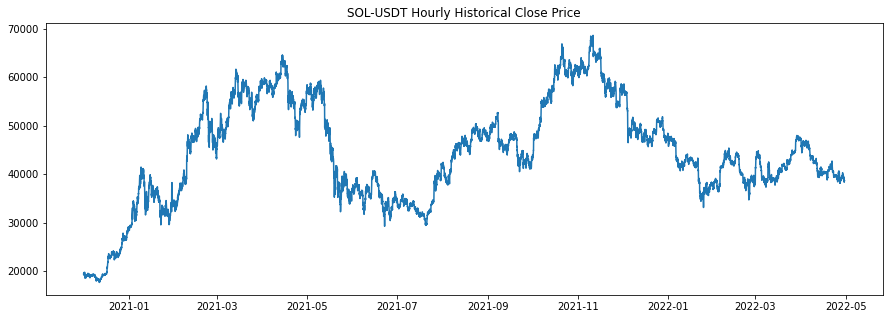

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(df_trans['open_time'],df_trans['close_price'])
plt.title('SOL-USDT Hourly Historical Close Price')
plt.show()

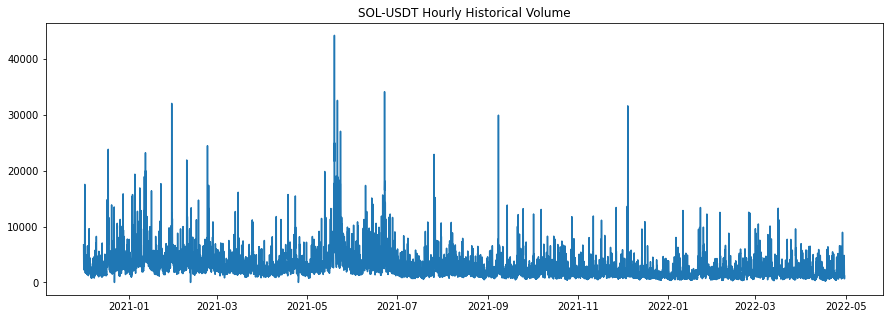

In [ ]:
plt.figure(figsize = (15,5))
# plt.plot(range(df_trans.shape[0]),df_trans['volume'])
plt.plot(df_trans['open_time'],df_trans['volume'])
plt.title('SOL-USDT Hourly Historical Volume')
plt.show()

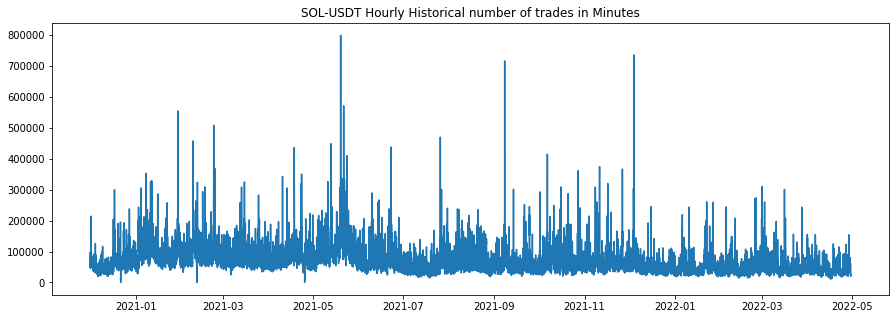

In [ ]:
plt.figure(figsize = (15,5))
# plt.plot(range(df_trans.shape[0]),df_trans['volume'])
plt.plot(df_trans['open_time'],df_trans['Number_of_trades'])
plt.title('SOL-USDT Hourly Historical number of trades in Minutes')
plt.show()

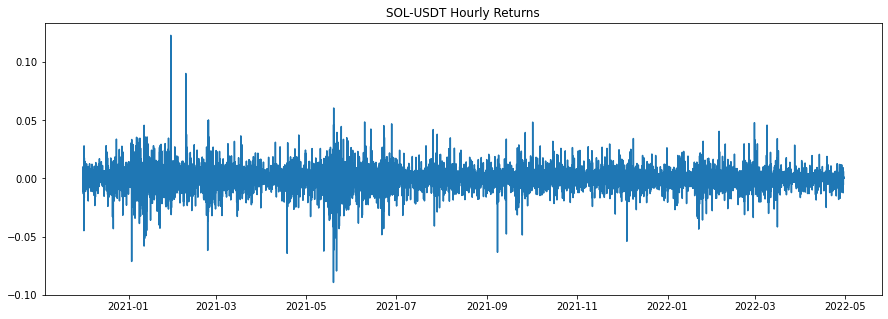

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(df_trans['open_time'],df_trans['return'])
plt.title('SOL-USDT Hourly Returns')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


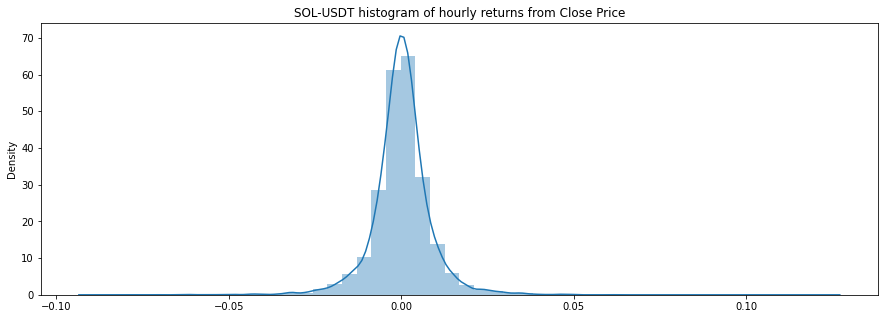

In [ ]:
plt.figure(figsize = (15,5))
his = df_trans[["open_time","return"]].set_index("open_time")
sns.distplot(his);
# plt.plot(df_trans[["close_time","return"]]['return'].hist(bins=50))
plt.title('SOL-USDT histogram of hourly returns from Close Price')
plt.show()

#Preprocess

In [ ]:
#Create Sequence feature
window_size=4
x_close,x_return,y_close,y_return = window_return(df_trans["close_price"].values, window_size)
print(f"x_close.shape : {x_close.shape}")
print(f"x_return.shape : {x_return.shape}")
print(f"y_close.shape : {y_close.shape}")
print(f"y_return.shape : {y_return.shape}")

x_close.shape : (12346, 4)
x_return.shape : (12346, 3)
y_close.shape : (12346, 1)
y_return.shape : (12346, 1)


In [ ]:
# Split data tuples x-(train, val, test), y-(train, val, test)
lst_x_close ,lst_y_close = split(x_close, y_close, 0.8, 0.1)
lst_x_return ,lst_y_return = split(x_return, y_return, 0.8, 0.1)

In [ ]:
print(f"Shape Price:{lst_x_close[0].shape} ,Val:{lst_x_close[1].shape}, Test:{lst_x_close[2].shape}")
print(f"Shape Return:{lst_x_return[0].shape} ,Val:{lst_x_return[1].shape}, Test:{lst_x_return[2].shape}")

Shape Price:(9876, 4) ,Val:(1236, 4), Test:(1234, 4)
Shape Return:(9876, 3) ,Val:(1236, 3), Test:(1234, 3)


In [ ]:
print(f"Shape Price:{lst_y_close[0].shape} ,Val:{lst_y_close[1].shape}, Test:{lst_y_close[2].shape}")
print(f"Shape Return:{lst_y_return[0].shape} ,Val:{lst_y_return[1].shape}, Test:{lst_y_return[2].shape}")

Shape Price:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)
Shape Return:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)


In [ ]:
#Normalize Data form train data set
#Fit Normalize tools
min_max_scaler = MinMaxScaler().fit(lst_x_return[0].reshape(-1,1))
lst_x_norm   ,lst_y_norm= norm_val(min_max_scaler, lst_x_return, lst_y_return)
print(f"Shape x:{lst_x_norm[0].shape} ,Val:{lst_x_norm[1].shape}, Test:{lst_x_norm[2].shape}")
print(f"Shape y:{lst_y_norm[0].shape} ,Val:{lst_y_norm[1].shape}, Test:{lst_y_norm[2].shape}")

Shape x:(9876, 3) ,Val:(1236, 3), Test:(1234, 3)
Shape y:(9876, 1) ,Val:(1236, 1), Test:(1234, 1)


In [ ]:
#Create data train - validate - test ( Size , Time , Feature)
#Create x array
x_train_norm = lst_x_norm[0]
x_val_norm   = lst_x_norm[1]
x_test_norm  = lst_x_norm[2]

#Create y array
y_train_norm = lst_y_norm[0]
y_val_norm   = lst_y_norm[1]
y_test_norm  = lst_y_norm[2]
y_test = lst_y_close[2]

print(f"\n x_train_norm.shape {x_train_norm.shape}{y_train_norm.shape} \n{x_train_norm[0]} -->y= {y_train_norm[0]}")
print(f"\n x_val_norm.shape {x_val_norm.shape}{y_val_norm.shape} \n{x_val_norm[0]} -->y={y_val_norm[0]}")
print(f"\n x_test_norm.shape {x_test_norm.shape}{y_test_norm.shape}\n{x_test_norm[0]} -->y={y_test_norm[0]}")


 x_train_norm.shape (9876, 3)(9876, 1) 
[0.42729119 0.44342365 0.47781528] -->y= [0.4666586]

 x_val_norm.shape (1236, 3)(1236, 1) 
[0.45884285 0.44331051 0.44356258] -->y=[0.44567469]

 x_test_norm.shape (1234, 3)(1234, 1)
[0.46339077 0.44250137 0.43852559] -->y=[0.46841221]


In [ ]:
len(lst_x_norm)

3

In [ ]:
lst_x_norm

[array([[0.42729119, 0.44342365, 0.47781528],
        [0.48534053, 0.52012282, 0.50883941],
        [0.50365506, 0.49242097, 0.51532901],
        ...,
        [0.48674425, 0.47997647, 0.50071365],
        [0.46228916, 0.48292791, 0.47270784],
        [0.48970105, 0.47946242, 0.46384365]]),
 array([[0.45884285, 0.44331051, 0.44356258],
        [0.4534498 , 0.45370257, 0.45582047],
        [0.46927865, 0.47140547, 0.44791081],
        ...,
        [0.49232791, 0.48847977, 0.50677442],
        [0.46520067, 0.48338129, 0.47772547],
        [0.48722418, 0.48156253, 0.46057082]]),
 array([[0.46339077, 0.44250137, 0.43852559],
        [0.44810371, 0.44412188, 0.47405389],
        [0.46502045, 0.49512194, 0.52280592],
        ...,
        [0.4594927 , 0.43914859, 0.46154374],
        [0.44862839, 0.47108114, 0.47066756],
        [0.4916015 , 0.49118564, 0.49588515]])]

In [ ]:
x_train_norm

array([[0.42729119, 0.44342365, 0.47781528],
       [0.48534053, 0.52012282, 0.50883941],
       [0.50365506, 0.49242097, 0.51532901],
       ...,
       [0.48674425, 0.47997647, 0.50071365],
       [0.46228916, 0.48292791, 0.47270784],
       [0.48970105, 0.47946242, 0.46384365]])

In [ ]:
#Convert to float32
x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

#Create Model

In [ ]:
model = Sequential()
model.add(tf.keras.layers.InputLayer((None,1), name='Input'))
model.add(SimpleRNN(units = 128, activation='relu',return_sequences = True))
model.add(Dropout(0.25))
model.add(SimpleRNN(units = 256, activation='relu',return_sequences = True))
model.add(Dropout(0.25))
# model.add(Dense(32, activation='relu'))
model.add(SimpleRNN(units = 256, activation='relu',return_sequences = False))
model.add(Dropout(0.25))

model.add(Dense(1, activation='linear'))

opt = SGD(learning_rate=0.0001, decay=1e-5, momentum=0.9, nesterov=True)

model.compile(loss='mse', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 128)         16640     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 256)         98560     
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

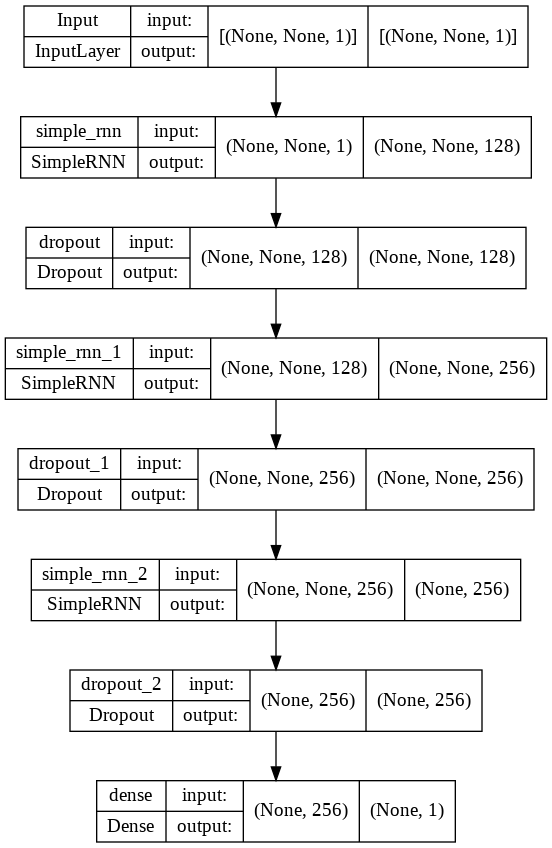

In [ ]:
tf.keras.utils.plot_model(model, 'SimpleRNN_model_summary.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

In [ ]:
os.system(f"rm *.hdf5")
checkpoint = "seq_SimpleRNN_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
hist = model.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=30,
                  callbacks=[model_checkpoint_callback])

Epoch 1/30
155/155 [==============================] - 6s 14ms/step - loss: 0.1134 - mean_absolute_error: 0.3054 - mean_squared_error: 0.1134 - val_loss: 0.0115 - val_mean_absolute_error: 0.0952 - val_mean_squared_error: 0.0115
Epoch 2/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0139 - mean_absolute_error: 0.0940 - mean_squared_error: 0.0139 - val_loss: 0.0031 - val_mean_absolute_error: 0.0394 - val_mean_squared_error: 0.0031
Epoch 3/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0086 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0086 - val_loss: 0.0040 - val_mean_absolute_error: 0.0488 - val_mean_squared_error: 0.0040
Epoch 4/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0080 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0080 - val_loss: 0.0041 - val_mean_absolute_error: 0.0500 - val_mean_squared_error: 0.0041
Epoch 5/30
155/155 [==============================] - 2s 11ms/step - loss: 0.0080 - mean_abs

#Evaluate model

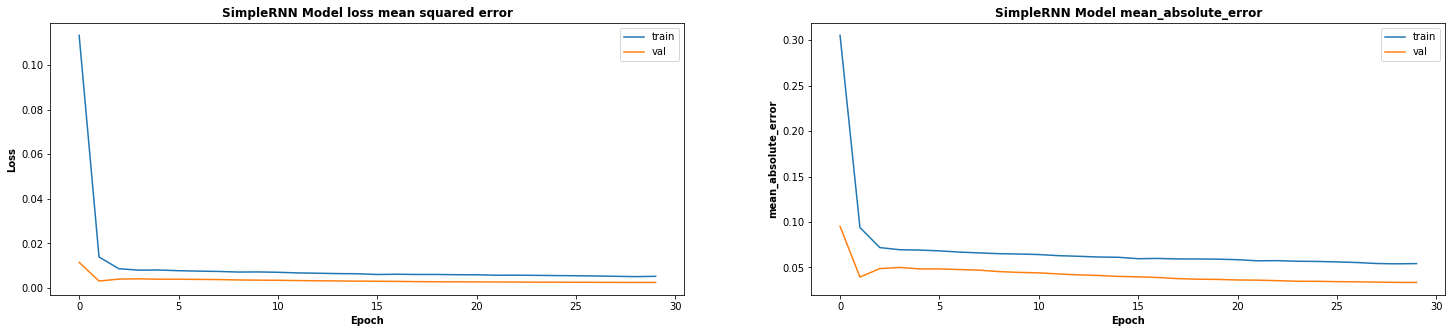

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(25,5))

plt.subplot(121)
plt.plot( hist.history['loss'])
plt.plot( hist.history['val_loss'])
plt.title('SimpleRNN Model loss mean squared error', fontweight="bold")
plt.ylabel('Loss', fontweight="bold")
plt.xlabel('Epoch', fontweight="bold")
plt.legend(['train','val'], loc='upper right')

plt.subplot(122)
plt.plot( hist.history['mean_absolute_error'])
plt.plot( hist.history['val_mean_absolute_error'])
plt.title('SimpleRNN Model mean_absolute_error', fontweight="bold")
plt.ylabel('mean_absolute_error', fontweight="bold")
plt.xlabel('Epoch', fontweight="bold")
plt.legend(['train','val'], loc='upper right')


plt.show()

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('seq_SimpleRNN_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : seq_SimpleRNN_bestmodel_epoch030.hdf5


In [ ]:
seq_best = tf.keras.models.load_model(bestmodel_file, compile=True)

In [ ]:
#Evaluate the model from last epoch
score = model.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(model.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(model.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 0.0010706846369430423), ('mean_absolute_error', 0.02261126972734928), ('mean_squared_error', 0.0010706846369430423)]


In [ ]:
#Evaluate the model from best epoch
score = seq_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(seq_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(seq_best.metrics_names[0],score)]}")

Test results (model from the best epoch) :[('loss', 0.0010706846369430423), ('mean_absolute_error', 0.02261126972734928), ('mean_squared_error', 0.0010706846369430423)]


In [ ]:
true_price = lst_y_close[2]

y_last_norm = model.predict(x_test_norm).reshape(-1,1)
y_last_preds = min_max_scaler.inverse_transform(y_last_norm)
y_last_price = (lst_x_close[2][:,0].reshape(-1,1)*(1+y_last_preds))

y_best_norm = seq_best.predict(x_test_norm).reshape(-1,1)
y_best_preds = min_max_scaler.inverse_transform(y_best_norm)
y_best_price = (lst_x_close[2][:,0].reshape(-1,1)*(1+y_best_preds))

In [ ]:
rmse = np.sqrt(np.mean(((y_best_price - true_price) ** 2)))
rmse

367.77793521024824

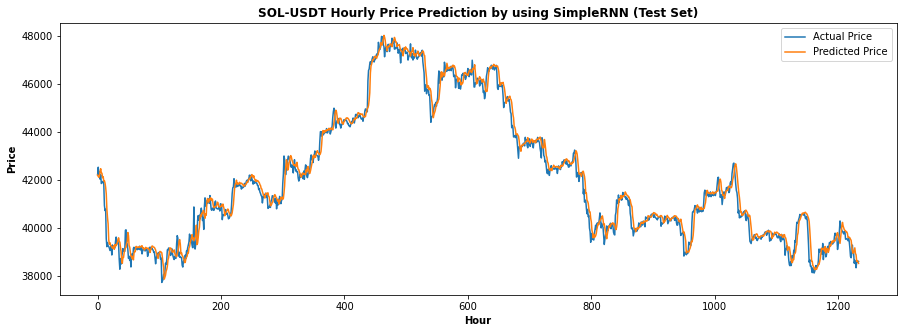

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot(true_price)
plt.plot(y_best_price)
plt.title('SOL-USDT Hourly Price Prediction by using SimpleRNN (Test Set)', fontweight="bold")
plt.ylabel('Price', fontweight="bold")
plt.xlabel('Hour', fontweight="bold")
plt.legend(['Actual Price','Predicted Price'], loc='upper right')
plt.show()

In [ ]:
best_mse  = mean_squared_error(true_price,y_best_price)
best_mae  = mean_absolute_error(true_price,y_best_price)
last_mse  = mean_squared_error(true_price,y_last_price)
last_mae  = mean_absolute_error(true_price,y_last_price)

print(f"Best model mean_squared_error : {best_mse} ,mean_absolute_error : {best_mae}")
print(f"Last model mean_squared_error : {last_mse} ,mean_absolute_error : {last_mae}")


Best model mean_squared_error : 135260.60962751354 ,mean_absolute_error : 254.47660258476682
Last model mean_squared_error : 135260.60962751354 ,mean_absolute_error : 254.47660258476682


In [ ]:
np.std(y_best_price)/np.mean(y_best_price)

0.06397051921629467

#Investment Strategy

In [ ]:
lst_x_close

[array([[19393.6 , 19175.78, 19259.98, 19439.48],
        [19175.78, 19259.98, 19439.48, 19381.25],
        [19259.98, 19439.48, 19381.25, 19499.99],
        ...,
        [42824.79, 43029.01, 42951.01, 43190.01],
        [43029.01, 42951.01, 43190.01, 43071.66],
        [42951.01, 43190.01, 43071.66, 42891.12]]),
 array([[43190.01, 43071.66, 42891.12, 42894.05],
        [43071.66, 42891.12, 42894.05, 42918.6 ],
        [42891.12, 42894.05, 42918.6 , 42647.4 ],
        ...,
        [41791.1 , 42053.19, 42009.91, 42215.67],
        [42053.19, 42009.91, 42215.67, 42151.66],
        [42009.91, 42215.67, 42151.66, 41914.33]]),
 array([[42215.67, 42151.66, 41914.33, 41869.16],
        [42151.66, 41914.33, 41869.16, 42208.71],
        [41914.33, 41869.16, 42208.71, 42520.99],
        ...,
        [38642.24, 38543.11, 38331.54, 38564.44],
        [38543.11, 38331.54, 38564.44, 38560.15],
        [38331.54, 38564.44, 38560.15, 38608.63]])]

In [ ]:
df_trans.head()

,symbol,open_time,close_price,volume,Number_of_trades,return
28728,BTCUSDT,2020-12-01 00:00:00,19393.60,6736.145261,96156,0.000000
28729,BTCUSDT,2020-12-01 01:00:00,19175.78,4761.075837,73158,-0.011232
28730,BTCUSDT,2020-12-01 02:00:00,19259.98,3291.466200,63576,0.004391
28731,BTCUSDT,2020-12-01 03:00:00,19439.48,3745.422077,68293,0.009320
28732,BTCUSDT,2020-12-01 04:00:00,19381.25,2732.124008,50985,-0.002995


In [ ]:
type(lst_x_close)

list

In [ ]:
len(lst_x_close)

3

In [ ]:
lst_x_close[1][:,-1]

array([42894.05, 42918.6 , 42647.4 , ..., 42215.67, 42151.66, 41914.33])

In [ ]:
len(lst_y_close)

3

In [ ]:
pd.set_option('display.max_rows', 500)

result = pd.DataFrame({"price_t4":lst_x_close[2][:,-1].ravel()
              ,"true_price_t5":true_price.ravel()
              ,"SimpleRNN":y_best_price.ravel()})
result.head()

,price_t4,true_price_t5,SimpleRNN
0,41869.16,42208.71,42064.888750
1,42208.71,42520.99,42050.077239
2,42520.99,42233.16,42048.343205
3,42233.16,42320.15,42073.394619
4,42320.15,42023.10,42230.492101


In [ ]:
result.to_excel (r'/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/SimpleRNN_BTC_result.xlsx', index = False, header=True)

In [ ]:
result["SimpleRNN"][0]

87.9258570599556

In [ ]:
result[result["price_t4"]==87.71]

,price_t4,true_price_t5,LSTM
162,87.71,87.26,86.064827


In [ ]:
budget=1000
sol=0
budget_hist=[budget]
btcs_hist=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
for i in range(len(result)):
  print("---------------------------")
  if (result["price_t4"][i]<result["SimpleRNN"][i]) and (sol<=0):
    print("BUY: ", i)
    sol = budget/((1+fee)*result["price_t4"][i])
    budget = budget - (sol*((1+fee)*result["price_t4"][i]))
    budget=0
    temp_buy_price=result["price_t4"][i]
    cost=(sol*((1+fee)*result["price_t4"][i]))
    print("SOL buy price: ", result["price_t4"][i])
    print("SOL: ", sol)
    print("budget: ", budget)
    print("cost: ", (sol*((1+fee)*result["price_t4"][i])))
  elif (result["price_t4"][i]>result["SimpleRNN"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
    if (result["price_t4"][i]>(temp_buy_price)):
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      print("SOL sell price: ", result["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      sol = 0
    elif (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))):
      print("SELL (Case 2): ", i)
      print("SOL buy price: ", temp_buy_price)
      print("SOL sell price: ", result["price_t4"][i])
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
      budget = budget + (sol*((1-fee)*result["price_t4"][i]))
      sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0


  budget_hist=budget_hist+[budget]
  btcs_hist=btcs_hist+[sol]

---------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
---------------------------
---------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
Stopper value:  850.0000000000001
revenue:  1021.5560400916148
---------------------------
BUY:  3
SOL buy price:  88.36
SOL:  11.549745411804299
budget:  0
cost:  1021.5560400916148
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------

Text(0.5, 0, 'Hour')

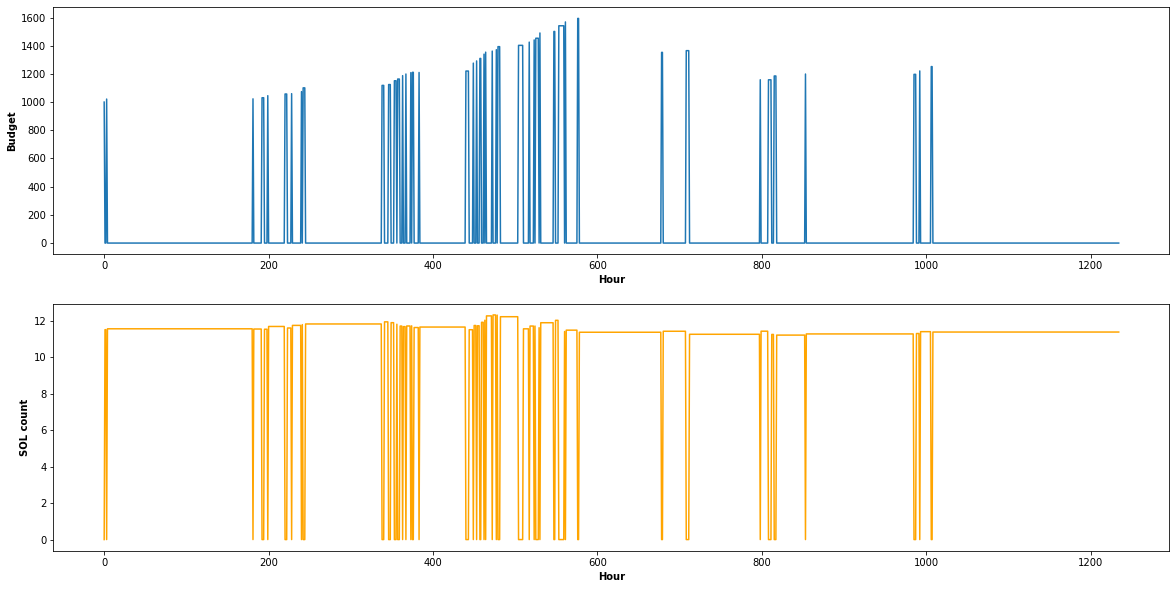

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("SOL count", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

Text(0, 0.5, 'SOL count')

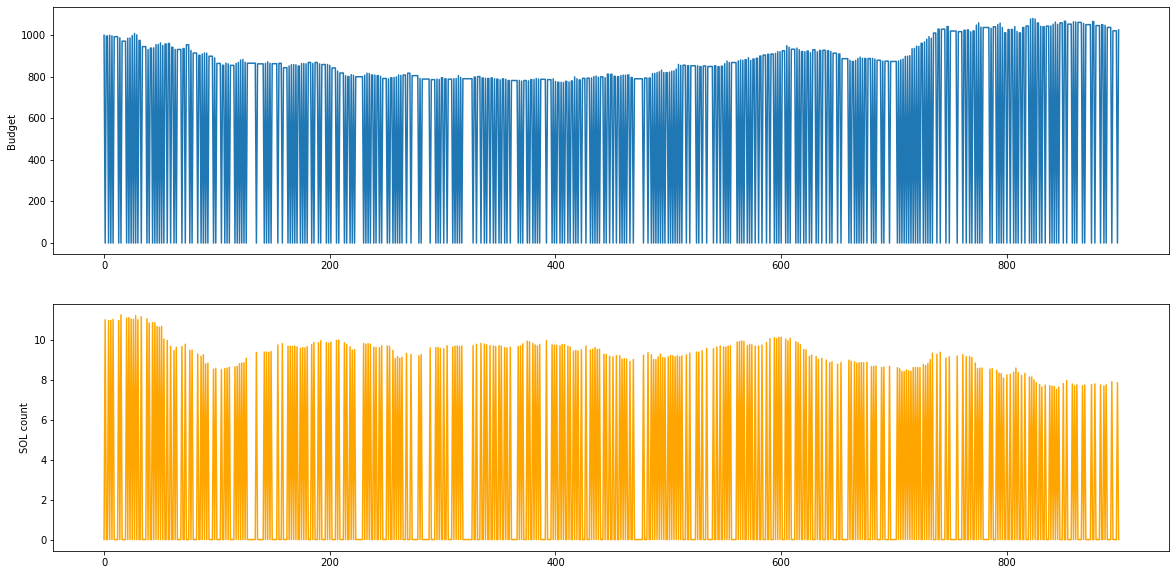

In [ ]:
budget=1000
btcs=0

budget_hist=[budget]
btcs_hist=[btcs]

for tomorrow in range(1,900):
  today = tomorrow-1
  going_up=result["LSTM"][tomorrow]>result["LSTM"][today]
  if going_up and budget>0:
    btcs=budget/result["true_price_t5"][today]
    budget=0
  elif btcs>0:
    budget=btcs*result["true_price_t5"][today]
    btcs=0
  budget_hist=budget_hist+[budget]
  btcs_hist=btcs_hist+[btcs]

fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("SOL count")

In [ ]:
print(btcs_hist)

[0, 10.986596352450011, 0, 0, 10.945547530913384, 0, 10.956341956486275, 0, 11.005929109617519, 0, 0, 0, 0, 10.94527032925146, 0, 11.22773694643428, 0, 0, 0, 0, 11.071618424954341, 0, 11.092806932578368, 0, 11.01974647164712, 0, 10.993043704560849, 0, 11.19072081413337, 0, 10.982121851589216, 0, 0, 11.135139081590802, 0, 0, 0, 0, 11.03631033346504, 0, 10.823308645829277, 0, 0, 10.848342319116728, 0, 10.835829813558345, 0, 10.65208972747391, 0, 10.614211421964503, 0, 10.652945136099726, 0, 10.018239452044433, 0, 0, 9.956784250581485, 0, 0, 9.653486208164054, 0, 0, 9.451080648622893, 0, 9.609996075250244, 0, 0, 0, 0, 9.653818215089712, 0, 0, 9.76461955103085, 0, 0, 0, 9.45203559513561, 0, 9.471351086287413, 0, 0, 0, 0, 9.274411541436118, 0, 0, 9.158786909407269, 0, 9.239763988789223, 0, 8.777066674692142, 0, 8.818587843552917, 0, 0, 0, 0, 8.51939769495626, 0, 8.560324855289446, 0, 0, 0, 0, 8.493026703911383, 0, 0, 8.543923787634382, 0, 8.5684388553935, 0, 8.61378356426378, 0, 0, 0, 0, 8.

In [ ]:
len(budget_hist)

900

In [ ]:
budget_hist[1497]

914.6384472347179

In [ ]:
print("Ended up with ",btcs_hist[899]," bitcoins, which equals",btcs_hist[899]*result["true_price_t5"][899],"dollars")
print("Ended up with ",budget_hist[899],"dollars")

Ended up with  0  bitcoins, which equals 0.0 dollars
Ended up with  1025.7702877834 dollars
